In [4]:
import pandas as pd
import numpy as np
from scipy import sparse
import os
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from IPython.display import display
import math

BitBIRCH Algorithm for clustering

In [72]:
def jt_isim(c_total, n_objects):
    
    sum_kq = np.sum(c_total)
    sum_kqsq = np.dot(c_total, c_total)
    a = (sum_kqsq - sum_kq)/2

    return a/(a + n_objects * sum_kq - sum_kqsq)

def max_separation(X):
   
    # Get the centroid of the set
    n_samples = len(X)
    linear_sum = np.sum(X, axis = 0)
    centroid = calc_centroid(linear_sum, n_samples)

    # Get the similarity of each molecule to the centroid
    pop_counts = np.sum(X, axis = 1)
    a_centroid = np.dot(X, centroid)
    sims_med = a_centroid / (pop_counts + np.sum(centroid) - a_centroid)

    # Get the least similar molecule to the centroid
    mol1 = np.argmin(sims_med)

    # Get the similarity of each molecule to mol1
    a_mol1 = np.dot(X, X[mol1])
    sims_mol1 = a_mol1 / (pop_counts + pop_counts[mol1] - a_mol1)

    # Get the least similar molecule to mol1
    mol2 = np.argmin(sims_mol1)

    # Get the similarity of each molecule to mol2
    a_mol2 = np.dot(X, X[mol2])
    sims_mol2 = a_mol2 / (pop_counts + pop_counts[mol2] - a_mol2)
    
    return (mol1, mol2), sims_mol1, sims_mol2

def calc_centroid(linear_sum, n_samples):
   
    return np.where(linear_sum >= n_samples * 0.5 , 1, 0)

def _iterate_sparse_X(X):
    
    n_samples, n_features = X.shape
    X_indices = X.indices
    X_data = X.data
    X_indptr = X.indptr

    for i in range(n_samples):
        row = np.zeros(n_features)
        startptr, endptr = X_indptr[i], X_indptr[i + 1]
        nonzero_indices = X_indices[startptr:endptr]
        row[nonzero_indices] = X_data[startptr:endptr]
        yield row

def _split_node(node, threshold, branching_factor):
    
    new_subcluster1 = _BFSubcluster()
    new_subcluster2 = _BFSubcluster()
    new_node1 = _BFNode(
        threshold=threshold,
        branching_factor=branching_factor,
        is_leaf=node.is_leaf,
        n_features=node.n_features,
        dtype=node.init_centroids_.dtype,
    )
    new_node2 = _BFNode(
        threshold=threshold,
        branching_factor=branching_factor,
        is_leaf=node.is_leaf,
        n_features=node.n_features,
        dtype=node.init_centroids_.dtype,
    )
    new_subcluster1.child_ = new_node1
    new_subcluster2.child_ = new_node2

    if node.is_leaf:
        if node.prev_leaf_ is not None:
            node.prev_leaf_.next_leaf_ = new_node1
        new_node1.prev_leaf_ = node.prev_leaf_
        new_node1.next_leaf_ = new_node2
        new_node2.prev_leaf_ = new_node1
        new_node2.next_leaf_ = node.next_leaf_
        if node.next_leaf_ is not None:
            node.next_leaf_.prev_leaf_ = new_node2  
    
    # O(N) implementation of max separation
    farthest_idx, node1_dist, node2_dist = max_separation(node.centroids_)    
    # Notice that max_separation is returning similarities and not distances
    node1_closer = node1_dist > node2_dist
    # Make sure node1 is closest to itself even if all distances are equal.
    # This can only happen when all node.centroids_ are duplicates leading to all
    # distances between centroids being zero.
    node1_closer[farthest_idx[0]] = True

    for idx, subcluster in enumerate(node.subclusters_):
        if node1_closer[idx]:
            new_node1.append_subcluster(subcluster)
            new_subcluster1.update(subcluster)
        else:
            new_node2.append_subcluster(subcluster)
            new_subcluster2.update(subcluster)
    return new_subcluster1, new_subcluster2


class _BFNode:

    def __init__(self, *, threshold, branching_factor, is_leaf, n_features, dtype):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.is_leaf = is_leaf
        self.n_features = n_features

        # The list of subclusters, centroids and squared norms
        # to manipulate throughout.
        self.subclusters_ = []
        self.init_centroids_ = np.zeros((branching_factor + 1, n_features), dtype=dtype)
        self.prev_leaf_ = None
        self.next_leaf_ = None

    def append_subcluster(self, subcluster):
        n_samples = len(self.subclusters_)
        self.subclusters_.append(subcluster)
        self.init_centroids_[n_samples] = subcluster.centroid_
        
        # Keep centroids as views. In this way
        # if we change init_centroids, it is sufficient
        self.centroids_ = self.init_centroids_[: n_samples + 1, :]
        
    def update_split_subclusters(self, subcluster, new_subcluster1, new_subcluster2):
        
        ind = self.subclusters_.index(subcluster)
        self.subclusters_[ind] = new_subcluster1
        self.init_centroids_[ind] = new_subcluster1.centroid_
        self.centroids_[ind] = new_subcluster1.centroid_
        self.append_subcluster(new_subcluster2)

    def insert_bf_subcluster(self, subcluster, set_bits):
        
        if not self.subclusters_:
            self.append_subcluster(subcluster)
            return False

        threshold = self.threshold
        branching_factor = self.branching_factor
        # We need to find the closest subcluster among all the
        # subclusters so that we can insert our new subcluster.
        a = np.dot(self.centroids_, subcluster.centroid_)
        sim_matrix = a / (np.sum(self.centroids_, axis = 1) + set_bits - a)
        closest_index = np.argmax(sim_matrix)
        closest_subcluster = self.subclusters_[closest_index]

        # If the subcluster has a child, we need a recursive strategy.
        if closest_subcluster.child_ is not None:
            split_child = closest_subcluster.child_.insert_bf_subcluster(subcluster, set_bits)

            if not split_child:
                # If it is determined that the child need not be split, we
                # can just update the closest_subcluster
                closest_subcluster.update(subcluster)
                self.init_centroids_[closest_index] = self.subclusters_[closest_index].centroid_
                self.centroids_[closest_index] = self.subclusters_[closest_index].centroid_
                return False

            # things not too good. we need to redistribute the subclusters in
            # our child node, and add a new subcluster in the parent
            # subcluster to accommodate the new child.
            else:
                new_subcluster1, new_subcluster2 = _split_node(
                    closest_subcluster.child_,
                    threshold,
                    branching_factor
                )
                self.update_split_subclusters(
                    closest_subcluster, new_subcluster1, new_subcluster2
                )

                if len(self.subclusters_) > self.branching_factor:
                    return True
                return False

        else:
            merged = closest_subcluster.merge_subcluster(subcluster, self.threshold)
            if merged:
                self.centroids_[closest_index] = closest_subcluster.centroid_
                self.init_centroids_[closest_index] = closest_subcluster.centroid_
                return False

            # not close to any other subclusters, and we still
            # have space, so add.
            elif len(self.subclusters_) < self.branching_factor:
                self.append_subcluster(subcluster)
                return False

            # We do not have enough space nor is it closer to an
            # other subcluster. We need to split.
            else:
                self.append_subcluster(subcluster)
                return True


class _BFSubcluster:

    def __init__(self, *, linear_sum = None, mol_indices = []):
        if linear_sum is None:
            self.n_samples_ = 0
            self.centroid_ = self.linear_sum_ = 0
            self.mol_indices = []
        else:
            self.n_samples_ = 1
            self.centroid_ = self.linear_sum_ = linear_sum
            self.mol_indices = mol_indices
        
        self.child_ = None

    def update(self, subcluster):
        self.n_samples_ += subcluster.n_samples_
        self.linear_sum_ += subcluster.linear_sum_
        self.mol_indices += subcluster.mol_indices
        self.centroid_ = calc_centroid(self.linear_sum_, self.n_samples_)

    def merge_subcluster(self, nominee_cluster, threshold):
       
        new_ls = self.linear_sum_ + nominee_cluster.linear_sum_
        new_n = self.n_samples_ + nominee_cluster.n_samples_
        new_centroid = calc_centroid(new_ls, new_n)
        
        jt_sim = jt_isim(new_ls + new_centroid, new_n + 1) * (new_n + 1) - jt_isim(new_ls, new_n) * (new_n - 1)
        
        if jt_sim >= threshold*2:
            (
                self.n_samples_,
                self.linear_sum_,
                self.centroid_,
                self.mol_indices
            ) = (new_n, new_ls, new_centroid, self.mol_indices + nominee_cluster.mol_indices)
            return True
        return False


class BitBirch():

    def __init__(
        self,
        *,
        threshold=0.5,
        branching_factor=50,
    ):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.index_tracker = 0
        self.first_call = True

    def fit(self, X):
        
        # TODO: Add input verification

        return self._fit(X)

    def _fit(self, X):
        threshold = self.threshold
        branching_factor = self.branching_factor

        n_features = X.shape[1]
        d_type = X.dtype

        # If partial_fit is called for the first time or fit is called, we
        # start a new tree.
        if self.first_call:
            # The first root is the leaf. Manipulate this object throughout.
            self.root_ = _BFNode(
                threshold=threshold,
                branching_factor=branching_factor,
                is_leaf=True,
                n_features=n_features,
                dtype=d_type,
            )
    
            # To enable getting back subclusters.
            self.dummy_leaf_ = _BFNode(
                threshold=threshold,
                branching_factor=branching_factor,
                is_leaf=True,
                n_features=n_features,
                dtype=d_type,
            )
            self.dummy_leaf_.next_leaf_ = self.root_
            self.root_.prev_leaf_ = self.dummy_leaf_

        # Cannot vectorize. Enough to convince to use cython.
        if not sparse.issparse(X):
            iter_func = iter
        else:
            iter_func = _iterate_sparse_X

        for sample in iter_func(X):
            set_bits = np.sum(sample)
            subcluster = _BFSubcluster(linear_sum=sample, mol_indices = [self.index_tracker])
            split = self.root_.insert_bf_subcluster(subcluster, set_bits)

            if split:
                new_subcluster1, new_subcluster2 = _split_node(
                    self.root_, threshold, branching_factor
                )
                del self.root_
                self.root_ = _BFNode(
                    threshold=threshold,
                    branching_factor=branching_factor,
                    is_leaf=False,
                    n_features=n_features,
                    dtype=d_type,
                )
                self.root_.append_subcluster(new_subcluster1)
                self.root_.append_subcluster(new_subcluster2)
            self.index_tracker += 1

        centroids = np.concatenate([leaf.centroids_ for leaf in self._get_leaves()])
        self.subcluster_centers_ = centroids
        self._n_features_out = self.subcluster_centers_.shape[0]
        
        self.first_call = False
        return self

    def _get_leaves(self):
        
        leaf_ptr = self.dummy_leaf_.next_leaf_
        leaves = []
        while leaf_ptr is not None:
            leaves.append(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf_
        return leaves
    
    def get_centroids(self):
        if self.first_call:
            raise ValueError('The model has not been fitted yet.')
        
        centroids = []
        for leaf in self._get_leaves():
            for subcluster in leaf.subclusters_:
                centroids.append(subcluster.centroid_)

        return centroids
    
    def get_cluster_mol_ids(self):
        if self.first_call:
            raise ValueError('The model has not been fitted yet.')
        
        clusters_mol_id = []
        for leaf in self._get_leaves():
            for subcluster in leaf.subclusters_:
                clusters_mol_id.append(subcluster.mol_indices)

        return clusters_mol_id

Read agonist active slipt 1 smiles files to obtain clusters

In [75]:
def smiles_to_fingerprints(smiles_list, fp_type='rdkit', fp_length=2048):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(str(smiles).strip())
        if mol is not None:
            if fp_type == 'rdkit':
                fp = AllChem.RDKFingerprint(mol, fpSize=fp_length)
            elif fp_type == 'morgan':
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_length)
            else:
                raise ValueError(f"Unsupported fingerprint type: {fp_type}")
            fingerprints.append(np.array(fp))
        else:
            print(f"Could not convert SMILES: {smiles}")
    
    return np.array(fingerprints)

def read_smi_file(file_path):
    with open(file_path, 'r') as f:
        smiles_list = [line.strip().split()[0] for line in f if line.strip()]
    return smiles_list

def cluster_smiles_data(input_path, 
                        output_path='ag_active_splits/clusters',
                        threshold=0.5,
                        branching_factor=30,
                        fp_type='rdkit', 
                        fp_length=2048):
    
    #Cluster SMILES data using BitBIRCH algorithm with output file generation

    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Read SMILES from input file
    smiles_list = read_smi_file(input_path)
    
    # Generate fingerprints
    X = smiles_to_fingerprints(smiles_list, 
                                fp_type=fp_type, 
                                fp_length=fp_length)
    
    # Perform BitBIRCH clustering
    birch_clustering = BitBirch(
        threshold=threshold, 
        branching_factor=branching_factor
    )
    birch_clustering.fit(X)
    
    # Get cluster information
    centroids = birch_clustering.get_centroids()
    cluster_mol_ids = birch_clustering.get_cluster_mol_ids()
    
    # Write cluster files
    cluster_summary = []
    for idx, (mol_indices, centroid) in enumerate(zip(cluster_mol_ids, centroids)):
        cluster_smiles = [smiles_list[i] for i in mol_indices]
        
        # Write cluster to separate file
        cluster_file = os.path.join(output_path, f'cluster_{idx}.smi')
        with open(cluster_file, 'w') as f:
            for smiles in cluster_smiles:
                f.write(f"{smiles}\n")
        
        # Collect cluster summary
        cluster_summary.append({
            'cluster_id': idx,
            'size': len(mol_indices),
            'file': cluster_file
        })
    
    # Write summary file
    summary_file = os.path.join(output_path, 'cluster_summary.txt')
    with open(summary_file, 'w') as f:
        f.write("Cluster ID | Size | Filename\n")
        f.write("-" * 40 + "\n")
        for cluster in cluster_summary:
            f.write(f"{cluster['cluster_id']:9} | {cluster['size']:4} | {cluster['file']}\n")
    
    print(f"Total Clusters: {len(cluster_mol_ids)}")
    print(f"Cluster summary saved to: {summary_file}")
    print(f"Individual cluster files saved in: {output_path}")

def main():
    input_path = 'ag_active_splits/ag_active_part1.smi'
    cluster_smiles_data(input_path)

if __name__ == "__main__":
    main()

Total Clusters: 23
Cluster summary saved to: ag_active_splits/clusters\cluster_summary.txt
Individual cluster files saved in: ag_active_splits/clusters


In [ ]:
Molecular structures of the clustered active molecules

Cluster Molecule Counts:
cluster_0.smi: 2 valid molecules
cluster_1.smi: 4 valid molecules
cluster_10.smi: 1 valid molecules
cluster_11.smi: 2 valid molecules
cluster_12.smi: 6 valid molecules
cluster_13.smi: 2 valid molecules
cluster_14.smi: 2 valid molecules
cluster_15.smi: 1 valid molecules
cluster_16.smi: 1 valid molecules
cluster_17.smi: 1 valid molecules
cluster_18.smi: 1 valid molecules
cluster_19.smi: 1 valid molecules
cluster_2.smi: 18 valid molecules
cluster_20.smi: 1 valid molecules
cluster_21.smi: 1 valid molecules
cluster_22.smi: 1 valid molecules
cluster_3.smi: 2 valid molecules
cluster_4.smi: 12 valid molecules
cluster_5.smi: 2 valid molecules
cluster_6.smi: 2 valid molecules
cluster_7.smi: 2 valid molecules
cluster_8.smi: 4 valid molecules
cluster_9.smi: 1 valid molecules


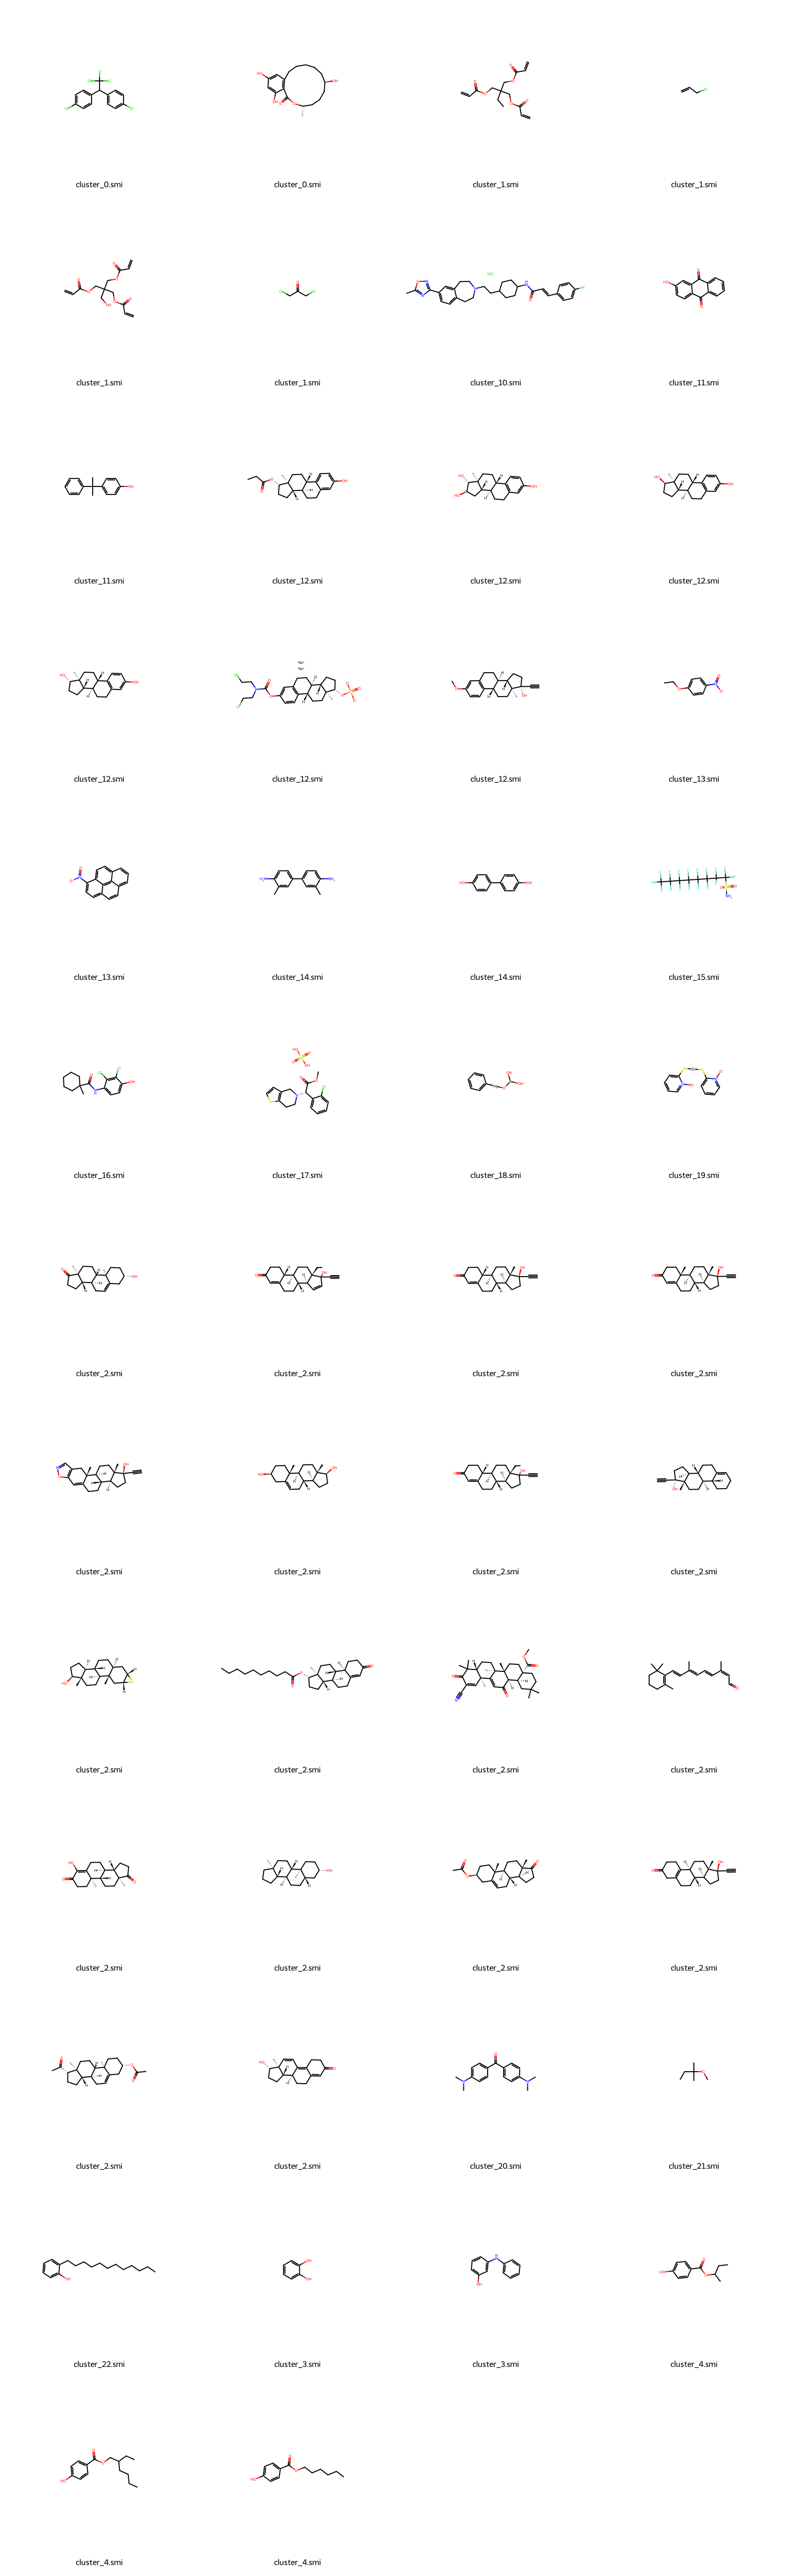

In [76]:
def debug_molecule_visualization(input_dir='ag_active_splits/clusters'):
    
    cluster_molecules = {}
    invalid_smiles = {}
    
    for cluster_file in sorted(os.listdir(input_dir)):
        if not cluster_file.endswith('.smi'):
            continue
        
        cluster_path = os.path.join(input_dir, cluster_file)
        
        try:
            with open(cluster_path, 'r') as f:
                smiles_list = [line.strip() for line in f if line.strip()]
        except IOError:
            print(f"Error reading file: {cluster_path}")
            continue
        
        cluster_molecules[cluster_file] = []
        invalid_smiles[cluster_file] = []
        
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                cluster_molecules[cluster_file].append(mol)
            else:
                invalid_smiles[cluster_file].append(smiles)
    
    # Collect all valid molecules with cluster labels
    all_molecules = []
    all_legends = []
    
    for cluster, molecules in cluster_molecules.items():
        for mol in molecules:
            all_molecules.append(mol)
            all_legends.append(f"{cluster}")
    
    print("Cluster Molecule Counts:")
    for cluster, molecules in cluster_molecules.items():
        print(f"{cluster}: {len(molecules)} valid molecules")
        if invalid_smiles[cluster]:
            print(f"  Invalid SMILES in {cluster}: {len(invalid_smiles[cluster])}")
    
    if all_molecules:
        return Draw.MolsToGridImage(
            all_molecules, 
            molsPerRow=4, 
            subImgSize=(400, 400),
            legends=all_legends
        )
    else:
        print("No valid molecules found")
        return None

debug_molecule_visualization()

Read agonist inactive slipt 1 smiles files to obtain clusters

In [156]:
def smiles_to_fingerprints(smiles_list, fp_type='rdkit', fp_length=2048):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(str(smiles).strip())
        if mol is not None:
            if fp_type == 'rdkit':
                fp = AllChem.RDKFingerprint(mol, fpSize=fp_length)
            elif fp_type == 'morgan':
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_length)
            else:
                raise ValueError(f"Unsupported fingerprint type: {fp_type}")
            fingerprints.append(np.array(fp))
        else:
            print(f"Could not convert SMILES: {smiles}")
    
    return np.array(fingerprints)

def read_smi_file(file_path):
    with open(file_path, 'r') as f:
        smiles_list = [line.strip().split()[0] for line in f if line.strip()]
    return smiles_list

def cluster_smiles_data(input_path, 
                        output_path='ag_inactive_splits/clusters_part1.1',
                        threshold=0.3,
                        branching_factor=15,
                        fp_type='rdkit', 
                        fp_length=2048):
    
    #Cluster SMILES data using BitBIRCH algorithm with output file generation
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Read SMILES from input file
    smiles_list = read_smi_file(input_path)
    
    # Generate fingerprints
    X = smiles_to_fingerprints(smiles_list, 
                                fp_type=fp_type, 
                                fp_length=fp_length)
    
    # Perform BitBIRCH clustering
    birch_clustering = BitBirch(
        threshold=threshold, 
        branching_factor=branching_factor
    )
    birch_clustering.fit(X)
    
    # Get cluster information
    centroids = birch_clustering.get_centroids()
    cluster_mol_ids = birch_clustering.get_cluster_mol_ids()
    
    # Write cluster files
    cluster_summary = []
    for idx, (mol_indices, centroid) in enumerate(zip(cluster_mol_ids, centroids)):
        cluster_smiles = [smiles_list[i] for i in mol_indices]
        
        # Write cluster to separate file
        cluster_file = os.path.join(output_path, f'cluster_{idx}.smi')
        with open(cluster_file, 'w') as f:
            for smiles in cluster_smiles:
                f.write(f"{smiles}\n")
        
        # Collect cluster summary
        cluster_summary.append({
            'cluster_id': idx,
            'size': len(mol_indices),
            'file': cluster_file
        })
    
    # Write summary file
    summary_file = os.path.join(output_path, 'cluster_summary.txt')
    with open(summary_file, 'w') as f:
        f.write("Cluster ID | Size | Filename\n")
        f.write("-" * 40 + "\n")
        for cluster in cluster_summary:
            f.write(f"{cluster['cluster_id']:9} | {cluster['size']:4} | {cluster['file']}\n")
    
    print(f"Total Clusters: {len(cluster_mol_ids)}")
    print(f"Cluster summary saved to: {summary_file}")
    print(f"Individual cluster files saved in: {output_path}")

def main():
    input_path = 'ag_inactive_splits/ag_inactive_part1.1'
    cluster_smiles_data(input_path)

if __name__ == "__main__":
    main()

[21:35:25] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16


Could not convert SMILES: CN1C[C@@H](C[C@@H]2c3cccc4ncc(C[C@@H]12)c34)C(=O)N[C@@]8(O[C@]7(O)N([C@@H](Cc5ccccc5)C(=O)N6CCC[C@H]67)C8=O)C(C)C
Total Clusters: 23
Cluster summary saved to: ag_inactive_splits/clusters_part1_copy\cluster_summary.txt
Individual cluster files saved in: ag_inactive_splits/clusters_part1_copy


Molecular structures of the clustered inactive molecules

[21:35:31] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16


Cluster Molecule Counts:
cluster_0.smi: 1 valid molecules
cluster_1.smi: 6 valid molecules
cluster_10.smi: 6 valid molecules
cluster_11.smi: 2 valid molecules
cluster_12.smi: 2 valid molecules
cluster_13.smi: 5 valid molecules
  Invalid SMILES in cluster_13.smi: 1
cluster_14.smi: 4 valid molecules
cluster_15.smi: 4 valid molecules
cluster_16.smi: 2 valid molecules
cluster_17.smi: 2 valid molecules
cluster_18.smi: 3 valid molecules
cluster_19.smi: 3 valid molecules
cluster_2.smi: 3 valid molecules
cluster_20.smi: 1 valid molecules
cluster_21.smi: 5 valid molecules
cluster_22.smi: 2 valid molecules
cluster_3.smi: 1 valid molecules
cluster_4.smi: 3 valid molecules
cluster_5.smi: 1 valid molecules
cluster_6.smi: 1 valid molecules
cluster_7.smi: 7 valid molecules
cluster_8.smi: 1 valid molecules
cluster_9.smi: 3 valid molecules


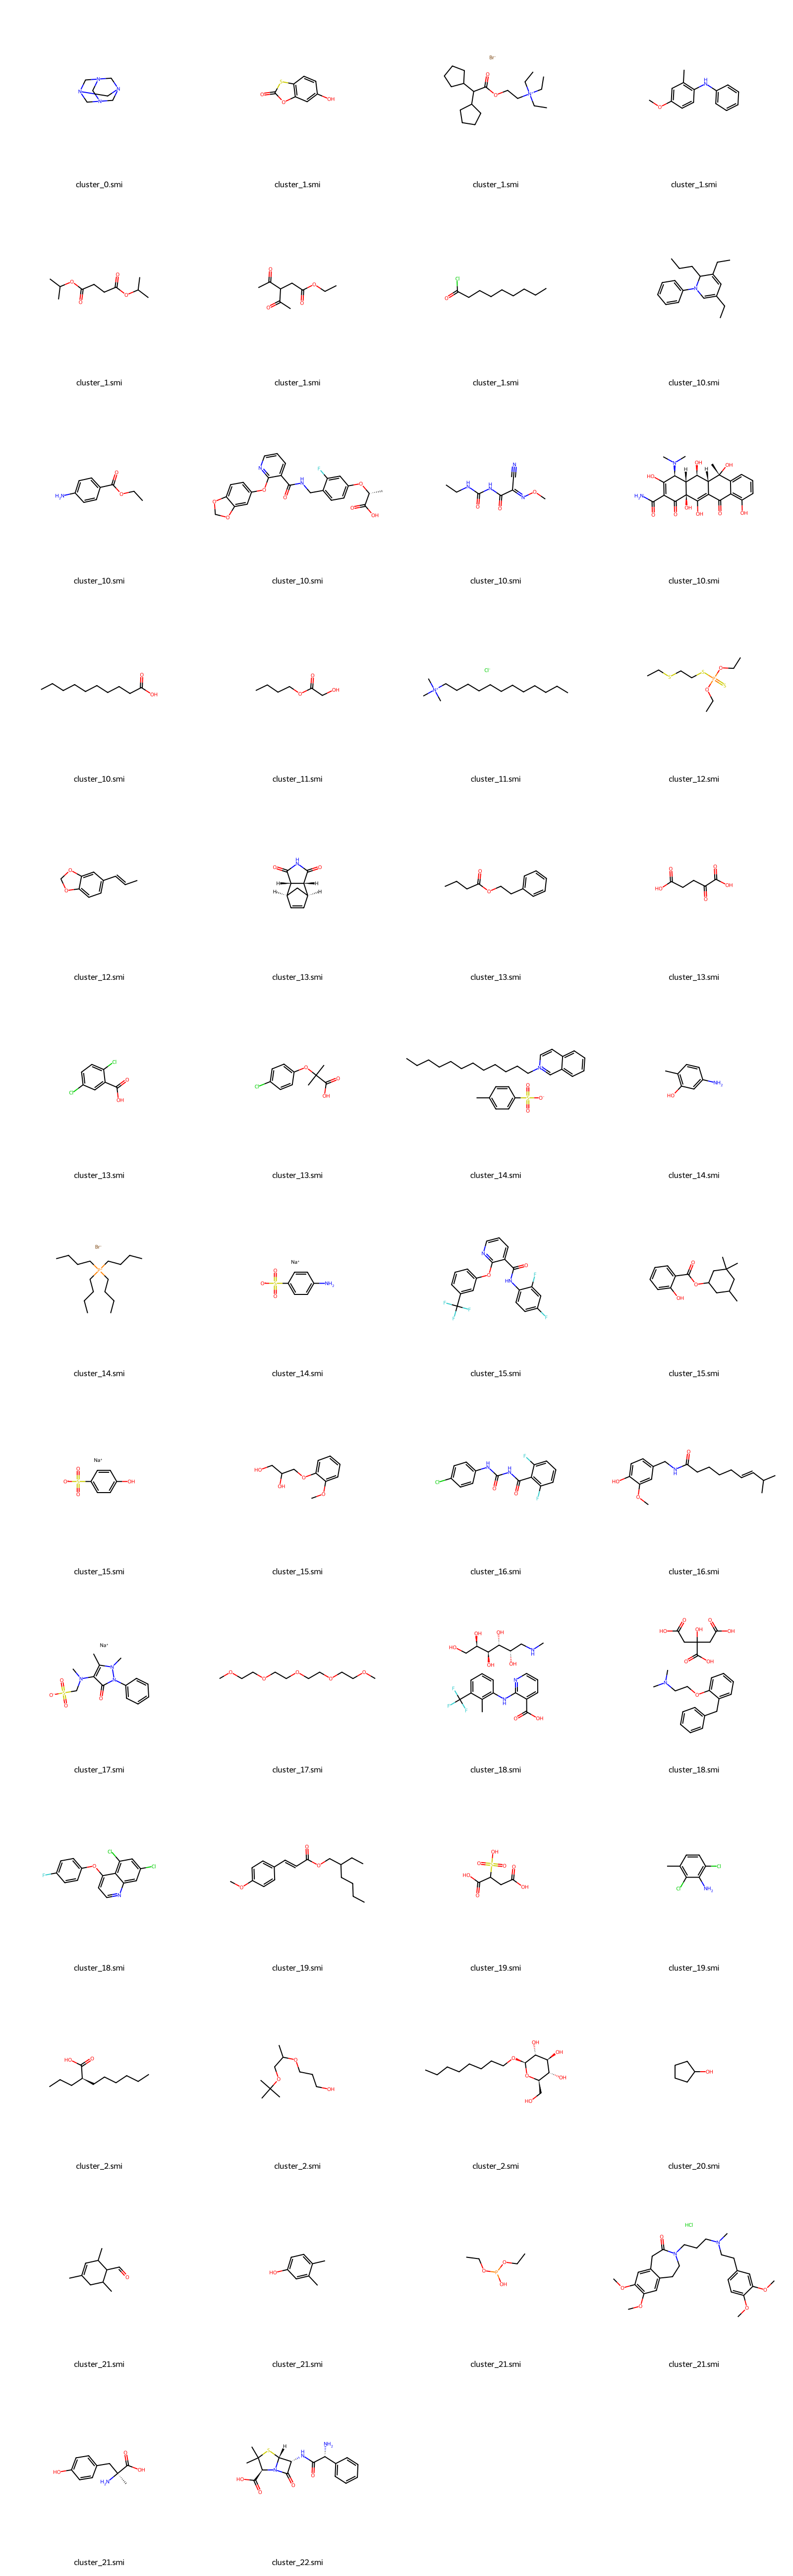

In [157]:
def debug_molecule_visualization(input_dir='ag_inactive_splits/clusters_part1_copy'):
    
    cluster_molecules = {}
    invalid_smiles = {}
    
    for cluster_file in sorted(os.listdir(input_dir)):
        if not cluster_file.endswith('.smi'):
            continue
        
        cluster_path = os.path.join(input_dir, cluster_file)
        
        try:
            with open(cluster_path, 'r') as f:
                smiles_list = [line.strip() for line in f if line.strip()]
        except IOError:
            print(f"Error reading file: {cluster_path}")
            continue
        
        cluster_molecules[cluster_file] = []
        invalid_smiles[cluster_file] = []
        
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                cluster_molecules[cluster_file].append(mol)
            else:
                invalid_smiles[cluster_file].append(smiles)
    
    # Collect all valid molecules with cluster labels
    all_molecules = []
    all_legends = []
    
    for cluster, molecules in cluster_molecules.items():
        for mol in molecules:
            all_molecules.append(mol)
            all_legends.append(f"{cluster}")
    
    print("Cluster Molecule Counts:")
    for cluster, molecules in cluster_molecules.items():
        print(f"{cluster}: {len(molecules)} valid molecules")
        if invalid_smiles[cluster]:
            print(f"  Invalid SMILES in {cluster}: {len(invalid_smiles[cluster])}")
    
    if all_molecules:
        return Draw.MolsToGridImage(
            all_molecules, 
            molsPerRow=4, 
            subImgSize=(400, 400),
            legends=all_legends
        )
    else:
        print("No valid molecules found")
        return None

debug_molecule_visualization()


Results from SMARTSminer

Total unique patterns found: 33

Error processing pattern: nan
Error message: No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float


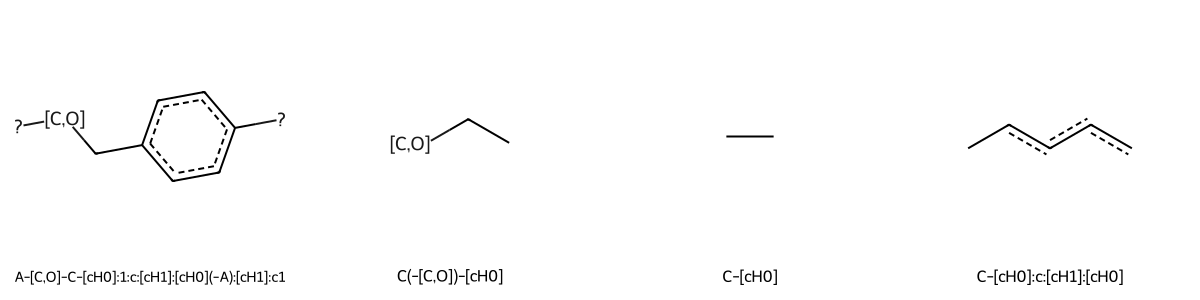

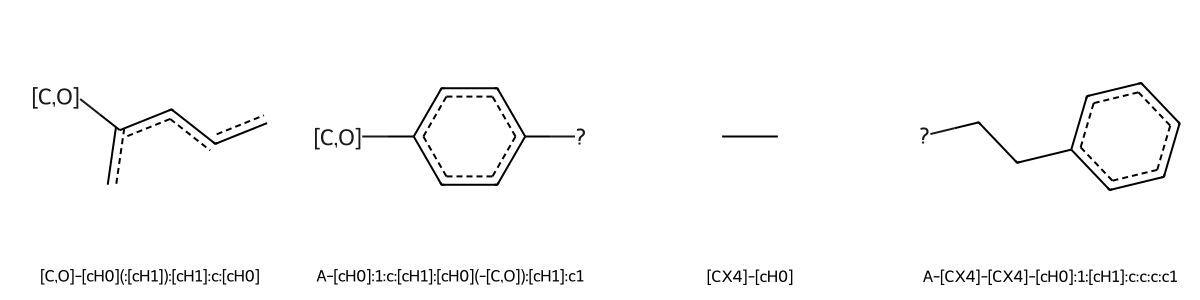

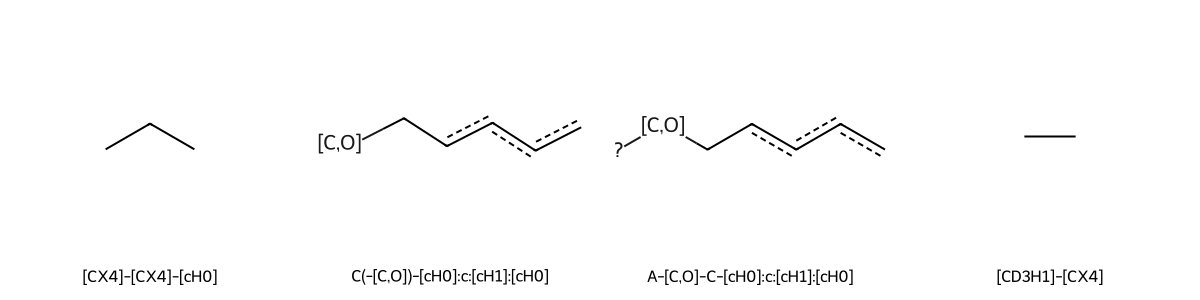

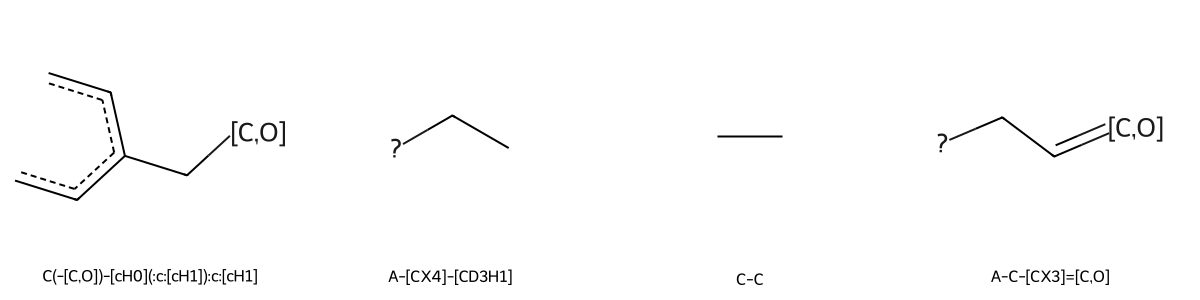

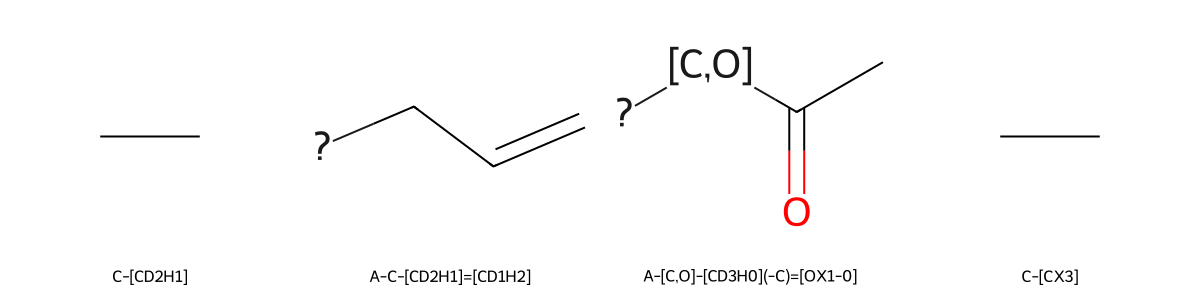

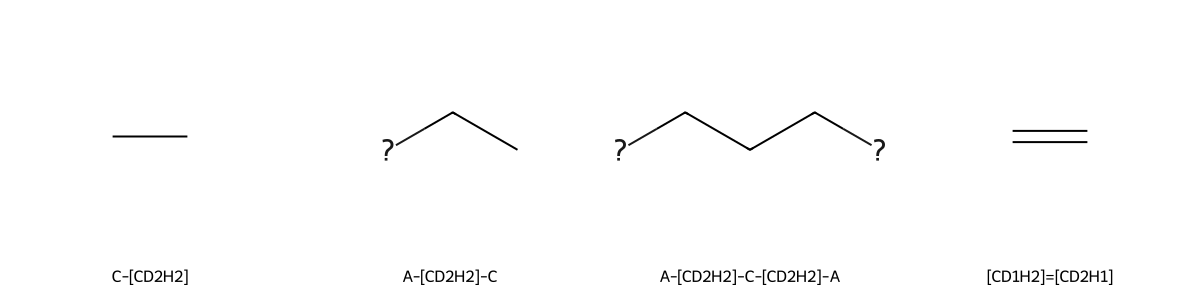

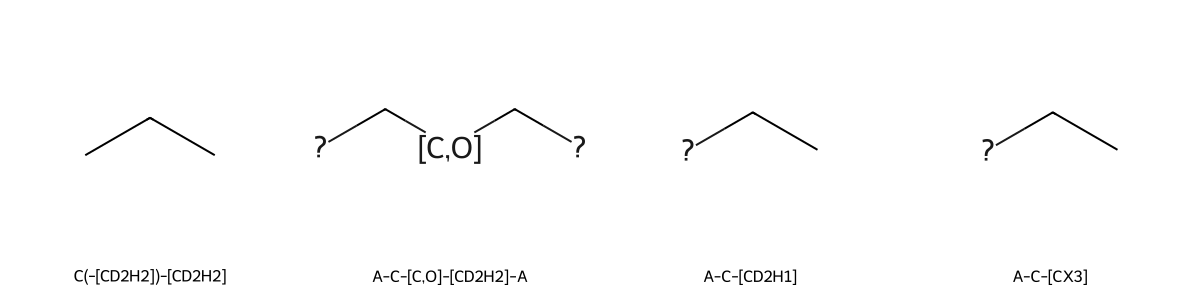

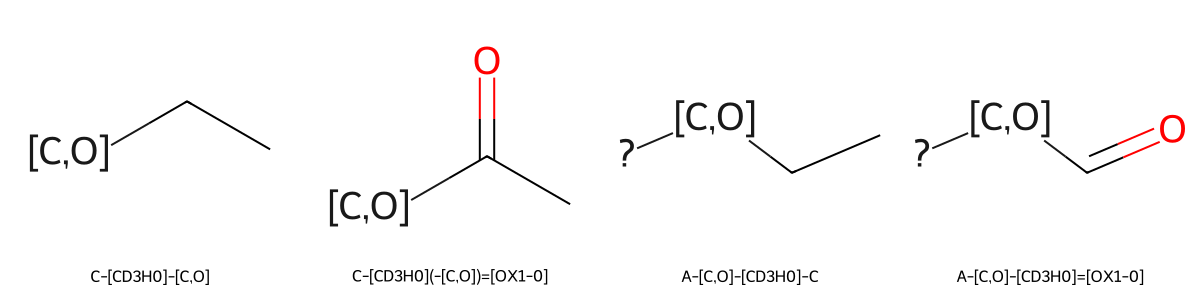

In [14]:
def process_and_visualize_patterns(excel_file_path, pattern_column='Pattern', mols_per_row=4):
    # Read Excel file
    df = pd.read_excel(excel_file_path)
    
    # Remove duplicates and reset index
    unique_patterns = df.drop_duplicates(subset=[pattern_column]).reset_index(drop=True)
    
    # Process patterns in batches
    mols = []
    legends = []
    
    print(f"Total unique patterns found: {len(unique_patterns)}\n")
    
    # Collect valid molecules and their patterns
    for pattern in unique_patterns[pattern_column]:
        try:
            mol = Chem.MolFromSmarts(pattern)
            if mol is not None:
                mols.append(mol)
                legends.append(pattern)
            else:
                print(f"Invalid pattern: {pattern}")
        except Exception as e:
            print(f"Error processing pattern: {pattern}")
            print(f"Error message: {str(e)}")
    
    # Calculate number of rows needed
    total_mols = len(mols)
    num_rows = math.ceil(total_mols / mols_per_row)
    
    # Display molecules in grids of 4 per row
    for row in range(num_rows):
        start_idx = row * mols_per_row
        end_idx = min(start_idx + mols_per_row, total_mols)
        
        row_mols = mols[start_idx:end_idx]
        row_legends = legends[start_idx:end_idx]
        
        img = Draw.MolsToGridImage(
            row_mols,
            molsPerRow=mols_per_row,
            subImgSize=(300, 300),
            legends=row_legends,
            returnPNG=False
        )
        display(img)    
    return unique_patterns

# Use in notebook
file_path = "Results/SMARTSminer@Clusters.xlsx"
patterns_df = process_and_visualize_patterns(file_path)

Until Next Time :)